---
layout: page
title: Intervalos de Confiança e Bootstrapping 
nav_order: 15
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/15-Bootstrapping.ipynb)

# Tópico 15 – Intervalos de Confiança e Bootstrapping
{: .no_toc .mb-2 }

Como na prática em Ciência de Dados raramente temos acesso à população inteira, na maior parte das vezes realizamos a inferência desejada com base em uma amostra. Porém, uma amostra nos possibilita ter apenas uma estimativa, e muitas vezes ficamos incertos sobre o quão precisa de fato é essa estimativa. Nessa aula, vamos aprender como quantificar a incerteza sobre nossas estimativas e como aplicar uma técnica pioneira que nos permite, com base em uma única amostra, simular diferentes cenários possíveis para nossas estimativas.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Entender o papel das distribuições amostrais na quantificação de incerteza sobre nossas estimativas.
2. Aprender sobre as potencialidades do bootstrap, e aprender como operacionalizá-lo na prática.
3. Introduzir as noções de percentis e de intervalos de confiança nesse contexto.

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
# Imports for this lesson.
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Animations
from IPython.display import display, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000&rm=minimal"
    width = 960
    height = 509
    display(IFrame(src, width, height))

## Recapitulando: Inferência Estatística

### Salários dos funcionários públicos da cidade de San Diego

Os salários de todos os funcionários públicos da cidade de San Diego [estão disponíveis publicamente](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2021&rpt=1). Nesse exemplo, estamos utilizando a base de dados mais recente (de 2022).

In [2]:
population = bpd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/15-Bootstrapping/data/2022_salaries.csv')
population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,Position,ElectedOfficial,Judicial,OtherPositions,MinPositionSalary,MaxPositionSalary,...,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula,EmployerURL,EmployerPopulation,LastUpdatedDate,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
0,2022,City,San Diego,Police,Police Officer II,False,False,NaN,87256,105435,...,7532,27561,3.0% @ 50,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
1,2022,City,San Diego,Police,Police Sergeant,False,False,NaN,105872,128003,...,19000,23508,3.0% @ 50,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
2,2022,City,San Diego,Fire-Rescue,Fire Engineer,False,False,NaN,69389,83886,...,20750,42217,3.0% @ 50,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
3,2022,City,San Diego,Retirement,Retirement Administrator,False,False,NaN,106371,424736,...,0,37792,1.0% @ 55,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
4,2022,City,San Diego,Police,Police Sergeant,False,False,NaN,105872,128003,...,17812,39604,3.0% @ 50,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12824,2022,City,San Diego,Library,Assistant Management Analyst,False,False,NaN,54434,66144,...,0,2,NaN,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
12825,2022,City,San Diego,Police,Word Processing Operator,False,False,NaN,38189,45947,...,0,0,NaN,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
12826,2022,City,San Diego,Public Utilities,Cashier,False,False,NaN,36712,44179,...,0,0,1.0% @ 55,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN
12827,2022,City,San Diego,Police,Police Officer II,False,False,NaN,87256,105435,...,0,0,NaN,www.sandiego.gov,1368395,06/27/2023,San Diego,NaN,False,NaN


Quando trabalhamos com um base de dados com um número grande de colunas, não conseguimos visualizá-las todas ao mesmo tempo. Nesses casos, é sempre uma boa ideia analisarmos os nomes das colunas.

In [3]:
population.columns

Index(['Year', 'EmployerType', 'EmployerName', 'DepartmentOrSubdivision',
       'Position', 'ElectedOfficial', 'Judicial', 'OtherPositions',
       'MinPositionSalary', 'MaxPositionSalary', 'ReportedBaseWage',
       'RegularPay', 'OvertimePay', 'LumpSumPay', 'OtherPay', 'TotalWages',
       'DefinedBenefitPlanContribution', 'EmployeesRetirementCostCovered',
       'DeferredCompensationPlan', 'HealthDentalVision',
       'TotalRetirementAndHealthContribution', 'PensionFormula', 'EmployerURL',
       'EmployerPopulation', 'LastUpdatedDate', 'EmployerCounty',
       'SpecialDistrictActivities', 'IncludesUnfundedLiability',
       'SpecialDistrictType'],
      dtype='object')

Como aqui estamos interessados apenas nos salários totais (`'TotalWages'`), selecionaremos (com `get`) apenas essa coluna.

In [4]:
population = population.get(['TotalWages'])
population

,TotalWages
0,384909
1,381566
2,350013
3,347755
4,345113
...,...
12824,29
12825,8
12826,6
12827,4


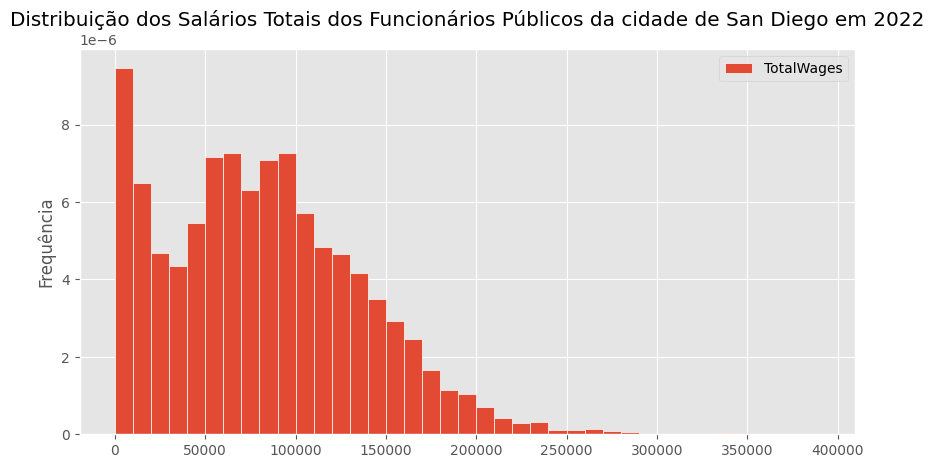

In [5]:
population.plot(kind='hist', bins=np.arange(0, 400000, 10000), density=True, ec='w', figsize=(10, 5),
                title='Distribuição dos Salários Totais dos Funcionários Públicos da cidade de San Diego em 2022')
plt.ylabel('Frequência');

### Salário mediano

- Podemos utilizar a função `.median()` para calcular o salário mediano de todos os funcionários públicos da cidade de San Diego.
- Note que, como temos a população _inteira_ disponível, essa mediana é um **parâmetro**, i.e. **não-aleatória**.

In [6]:
population_median = population.get('TotalWages').median()
population_median

78136.0

### Na prática, porém...

- Na prática, o processo de entrevistar **toda** a população (no caso mais de 12,000 funcionários) é caro e pode consumir muito tempo.
    - Além disso, muitas vezes é impossível entrevistar todos os indivíduos da população.

- O que fazemos então é aferir os salários com base em uma amostra aleatória (nesse exemplo tomamos $n = 500$).

### Revisão da terminologia

- O DataFrame completo de salários, i.e. `population.get(['TotalWages'])`, é a nossa **população**.

- Nós observamos uma **amostra** de tamanho $n = 500$ dessa população.

- Queremos determinar a **mediana populacional** (que é um _parâmetro_), mas como não temos acesso à população completa, utilizaremos a **mediana amostral** (que é uma _estatística_) como uma **estimativa** desse parâmetro.

- Nesse processo, esperamos que a mediana amostral seja próxima da mediana populacional.

### A mediana amostral

Vamos amostrar 500 funcionários aleatoriamente. Para fazer isso, podemos utilizar o método `.sample`.

In [7]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

# Take a sample of size 500.
my_sample = population.sample(500)
my_sample

,TotalWages
10301,27866
6913,71861
5163,91843
6445,77727
5861,84770
...,...
12493,1935
7020,70557
3002,121209
3718,109709


Nesse notebook, não vamos mais modificar `my_sample`, então esse DataFrame vai sempre se referir à essa amostra em particular.

In [8]:
# Compute the sample median.
sample_median = my_sample.get('TotalWages').median()
sample_median

76237.0

### O quão confiantes estamos que essa é uma boa estimativa?

- Nossa estimativa é função da amostra aleatória particular `my_sample`. Se tívessemos coletado outra amostra, a estimativa poderia ter sido diferente.

- **Agora, o quão diferente nossa estimativa poderia ter sido?** Nosssa _confiança_ na estimativa depende fundamentalmente da resposta à essa pergunta.

- The sample median is a random number. It comes from some distribution, which we don't know. 

- **Se** conhecéssmos a distribuição verdadeira da mediana amostral (i.e. a _distribuição amostral_), essa distribuição nos ajudaria a responder essa pergunta.
    - Distribuições mais "estreitas" (i.e. com baixa _variabilidade/dispersão_) $\Rightarrow$ nossa estimativa em geral não teria sido tão diferente.
    - Distribuições mais "largas" (i.e. com alta variabilidade/dispersão) $\Rightarrow$ nossa estimativa em geral teria sido bem diferente.

### Uma abordagem ineficiente

- Uma ideia natural aqui então seria: coletar repetidas amostras de tamanho $n = 500$ **da população** e calcular as medianas amostrais de cada uma.
    - Foi examente isso o que fizemos na aula anterior, quando calculamos a distribuição empírica das médias amostrais dos atrasos de vôos (como aproximação para a distribuição amostral).

In [9]:
sample_medians = np.array([])
for i in np.arange(1000):
    median = population.sample(500).get('TotalWages').median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([81686.5, 79641. , 75592. , 79469.5, 77175. , 75526.5, 77413. ,
       86007. , 78891.5, 71640.5, 78253. , 83384. , 82162. , 74003.5,
       79478. , 79985.5, 75580.5, 84105.5, 84890.5, 81649.5, 78085. ,
       78449. , 75220. , 74996. , 74392. , 78017.5, 83398.5, 78928. ,
       83277. , 73590. , 73691. , 84165. , 74246.5, 83854.5, 74342. ,
       79689. , 81256. , 80983.5, 79579.5, 78033.5, 75918. , 76480. ,
       76747.5, 78460.5, 77018. , 85621. , 79800. , 78172.5, 80487.5,
       80164.5, 75039. , 81065.5, 84117. , 77577. , 74250.5, 79980. ,
       75246. , 80619.5, 76118.5, 75835. , 79458.5, 79705.5, 83076.5,
       79501.5, 78588. , 75554.5, 83264. , 79714.5, 82792.5, 75455. ,
       77597.5, 71865. , 70303. , 77472. , 77054.5, 79156.5, 78637. ,
       74680.5, 76653. , 69339. , 72018. , 75271.5, 77726. , 77975. ,
       72222.5, 78741.5, 72568. , 74245.5, 79069. , 80487. , 71996. ,
       78742.5, 77119.5, 80751.5, 81273.5, 79862.5, 72562.5, 84078.5,
       73879. , 7655

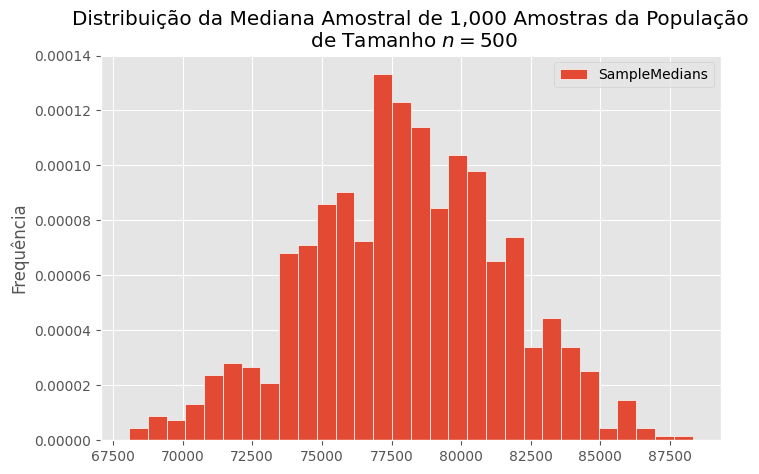

In [10]:
(bpd.DataFrame()
 .assign(SampleMedians=sample_medians)
 .plot(kind='hist', density=True,
       bins=30, ec='w', figsize=(8, 5),
       title='Distribuição da Mediana Amostral de 1,000 Amostras da População\n de Tamanho $n = 500$')
)
plt.ylabel("Frequência");

- Essa distribuição empírica da mediana amostral é uma aproximação para sua verdadeira distribuição amostral.

### E porque essa abordagem é ineficiente?

- Amostrar repetidas vezes da mesma população muitas vezes é infactível pelas mesmas razões pelas quais não trabalhamos com a população desde o começo!
    - Se pudéssemos fazer isso, porque não simplesmente coletar mais dados (i.e. uma amostra maior)?

- **Ideia pioneira**: se a distribuição da nossa amostra original `my_sample` se parece com a distribuição populacional, **podemos aproveitar esse fato para derivarmos uma boa aproximação para a distribuição amostral de interesse**. 

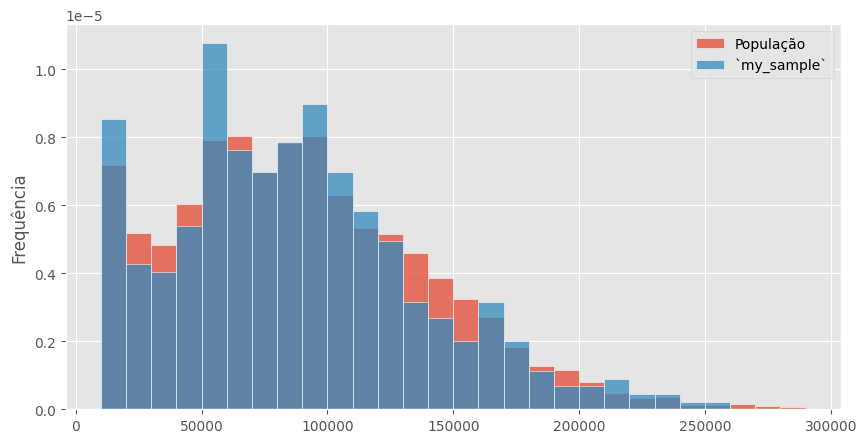

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
bins=np.arange(10_000, 300_000, 10_000)
population.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
my_sample.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
plt.legend(['População', '`my_sample`'])
plt.ylabel("Frequência");

Note que no histograma acima estamos comparando a _distribuição populacional_ com a _distribuição empírica_ de uma amostra em particular (`my_sample`), e **não** a distribuição das medianas amostrais de várias amostras como vimos até agora.

## Bootstrapping 🥾

### Bootstrapping

- **Ideia principal**: Utilizar a amostra no lugar da população.
    - Assumimos aqui que a amostra "se parece" com a população.
    - Logo, _reamostrar da amostra_, de uma certa maneira, é similar à reamostrar da própria população!
    - Denominamos o conjunto de técnicas que se baseiam em reamostragens a partir da amostra de **bootstrapping**.

In [12]:
show_bootstrapping_slides()

### Com reposição ou sem reposição?

- Nosso objetivo quando realizamos um bootstrap é gerar uma amostra do _mesmo tamanho_, porém com _algumas características_ diferentes da amostra original.

- Para ilustrar esse ponto, considere um exemplo simples onde vamos reamostrar repetidas vezes **sem reposição**, uma amostra original igual a [1, 2, 3].

In [13]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=False)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [2 1 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0


- Vamos agora repetir o mesmo experimento, mas dessa vez reamostrando **com reposição**:

In [14]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=True)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [3 2 1]     Median:  2.0
Resample:  [1 1 3]     Median:  1.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 1 2]     Median:  1.0
Resample:  [2 1 3]     Median:  2.0
Resample:  [3 3 3]     Median:  3.0
Resample:  [1 1 1]     Median:  1.0
Resample:  [2 2 3]     Median:  2.0
Resample:  [2 3 2]     Median:  2.0
Resample:  [3 3 2]     Median:  3.0


- Concluímos com esse exemplo que:
    - Quando amostramos _sem reposição_, as novas amostras (amostras bootstrap) são em um certo sentido "idênticas" à amostra original – muda se apenas a ordenação dos indivíduos.
        - Como consequência, todas as suas características (isto é, estatísticas), são _iguais_.
    - Por outro lado, quando amostramos _com reposição_, as amostras bootstrap em geral terão características diferentes da amostra original.
        - As estatísticas calculadas nas amostras bootstrap serão em geral diferentes das calculadas na amostra original, o que nos permite aferir _variabilidade das estimativas_ entre as amostras e/ou construir uma distribuição amostral para as estatísticas de interesse.

- Dessa forma, quando realizamos um bootstrap, sempre reamostramos **com reposição**, para garantir que as nossas amostras bootstrap possam ser diferentes da nossa amostra original.
    - O bootstrap funciona então como um processo que "imita", em um certo sentido, o ato de coletar novas amostras.

### Bootstrap na amostra de salários

Conforme dito anteriormente, para realizar o bootstrap na nossa amostra basta gerar novas amostras **reamostrando com reposição da nossa amostra original, `my_sample`**.

In [15]:
# Note that the population DataFrame, population, doesn't appear anywhere here.
# This is all based on one sample, my_sample.

np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

n_resamples = 5000
boot_medians = np.array([])

for i in range(n_resamples):
    
    # Resample from my_sample WITH REPLACEMENT.
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median.
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians.
    boot_medians = np.append(boot_medians, median)

In [16]:
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

### _Distribuição bootstrap_ da mediana amostral

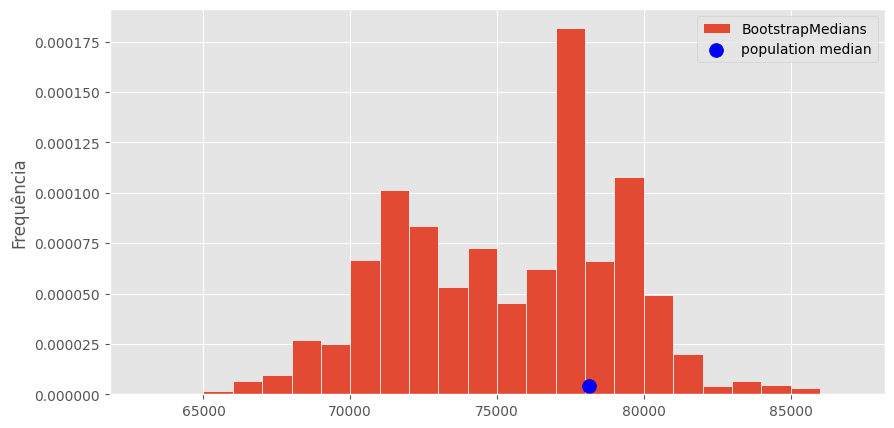

In [17]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(2)
plt.legend()
plt.ylabel("Frequência");

Apenas para termos uma referência do quão boa é nossa inferência, a mediana populacional é reportada no histograma acima como um <span style="color:blue"><b>ponto azul</b></span>.

**Lembre porém que, na maior parte das situações, não temos acesso à essa informação!**

### Mas afinal, como o bootstrap nos ajuda a responder nossa pergunta original?

Lembre que, aqui, iniciamos apenas com a mediana amostral:

In [18]:
my_sample.get('TotalWages').median()

76237.0

Com base nessa estimativa, podemos dizer apenas que o salário mediano da população é aproximadamente \\$76,237, mas não muito mais do que isso.

Em particular, não podemos afirmar nada acerca da _variabilidade_ dessa estimativa, isto é, o quão _confiantes_ (ou incertos!) estamos sobre esse valor.

Após realizarmos um bootstrap, porém, podemos gerar uma distribuição empírica da mediana amostral:

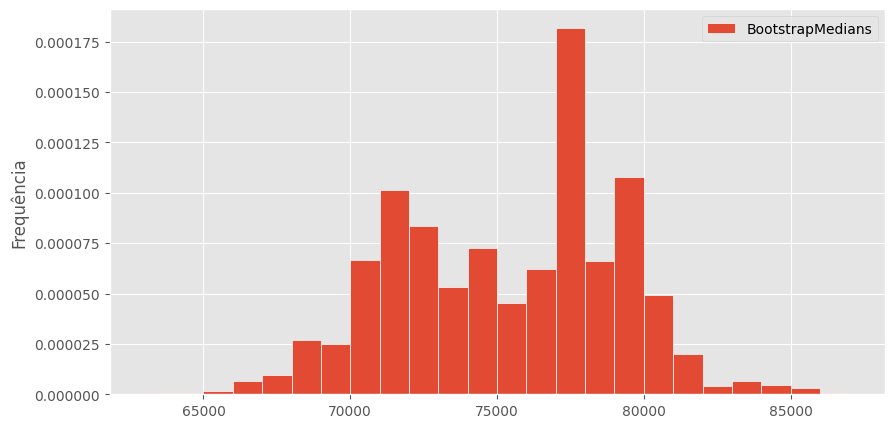

In [19]:
(bpd.DataFrame()
 .assign(BootstrapMedians=boot_medians)
 .plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
)
plt.legend()
plt.ylabel("Frequência");

e essa distribuição nos permite realizar afirmações do tipo

> O salário mediano na população está entre \\$68,000 e \\$82,000.

**Pergunta**: Poderíamos também dizer que o salário mediano na população está entre \\$70,000 e \\$80,000, ou entre \\$65,000 e \\$85,000. Qual desses dois intervalos você reportaria?

## Percentis

### Definição informal

> Seja $p$ um número entre 0 e 100. O $p$-ésimo percentil de um conjunto de observações é o número que é maior ou igual a $p\%$ de todos os valores do conjunto.

<center><img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/15-Bootstrapping/images/percentile2.jpg" width=600></center>

**Outro exemplo**: Se você está no percentil $80$ da altura de um certo conjunto de pessoas, isso significa que aproximadamente $80\%$ das pessoas desse conjunto são mais baixas que você, e que $20\%$ são mais altas.

<center><img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/15-Bootstrapping/images/percentile.svg" width=400></center>

### Calculando os percentis

- O pacote `numpy` contém uma função para calcular percentis, `np.percentile(array, p)`, que retorna o `p`-ésimo percentil de `array`. 
- Por enquanto, não entraremos em detalhes sobre como esse valor é calculado – nos concentraremos apenas em utilizar o resultado.
    - Retornaremos à esse ponto mais adiante, mas apenas para uma breve reflexão: você acha que ordenar a amostra, calcular as frequências correspondentes e encontrar o valor correspondente à frequência $p\%$ em geral é suficiente?

In [20]:
np.percentile([4, 6, 9, 2, 7], 50)

6.0

In [21]:
np.percentile([2, 4, 6, 7, 9], 50)

6.0

## Intervalos de confiança

Anteriormente, geramos uma distribuição boostrap da mediana amostral:

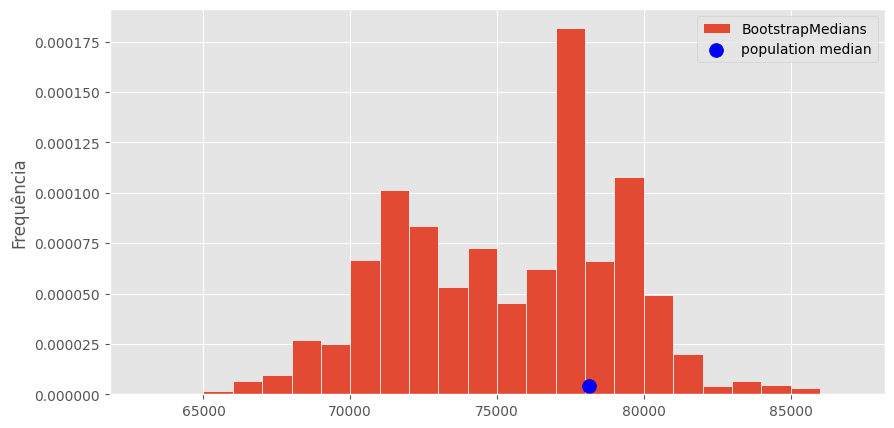

In [22]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(2)
plt.legend()
plt.ylabel("Frequência");

Com base nessa distribuição, o que podemos então afirmar em termos de percentis?

### Utilizando a distribuição bootstrap da mediana amostral

- Nossa mediana amostral é igual a \\$76,237.

- Conforme mencionamos anteriormente, acreditamos que a mediana populacional seja _próxima_ de \\$76,237, mas não sabemos _quão_ próxima.

- Como quantificar então a incerteza sobre essa estimativa?

- 💡 **Ideia:** Encontrar um intervalo que contenha **a maior parte** (por exemplo, 95%) das medianas amostrais na distribuição bootstrap. Intervalos desse tipo são denominados de **intervalos de confiança**.
    - Mais uma vez ressaltamos que aqui nosso principal objetivo é entender e aprender como utilizar os conceitos introduzidos – uma formalização completa do conceito de intervalo de confiança será feita em outras disciplinas mais adiante. 

### Definindo um intervalo de confiança

- No exemplo acima, queremos encontrar um intervalo $[x,y]$ que contenha aproximadamente 95% da área total da distribuição bootstrap. Denominamos esse intervalo de **intervalo de 95% de confiança** (IC95%).
    - Note que um intervalo de confiança _não é único_ – mais adiante veremos como calcular diferentes intervalos para um mesmo **nível de confiança**.

- Uma maneira de encontrar esse intervalo é encontrar dois pontos, $x$ e $y$, tais que:
    - A área _à esquerda_ de $x$ na distribuição bootstrap seja aproximadamente 2.5%.
    - A área _à direita_ de $y$ na distribuição bootstrap seja aproximadamente 2.5%.

- Pela definição de percentil dada acima, temos então que $x$ e $y$ são os percentis **2.5** e **97.5**, respectivamente.
    - Usualmente, $x$ e $y$ são respectivamente denominados **limite inferior** e **limite superior** do intervalo de confiança.  

### Encontrando os limites do IC95% com np.percentile

In [23]:
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

In [24]:
# Left endpoint.
left = np.percentile(boot_medians, 2.5)
left

68469.0

In [25]:
# Right endpoint.
right = np.percentile(boot_medians, 97.5)
right

81253.5

In [26]:
# Therefore, our interval is:
[left, right]

[68469.0, 81253.5]

Utilizamos códigos como esse acima o **tempo todo** em Ciência de Dados!

### Visualizando nosso IC95%
- Vamos agora plotar o intervalo que acabamos de calcular no histograma anterior.
- Lembre que, pela definição do IC95%, que 95% das medianas da distribuição bootstrap estão contidas nesse intervalo.

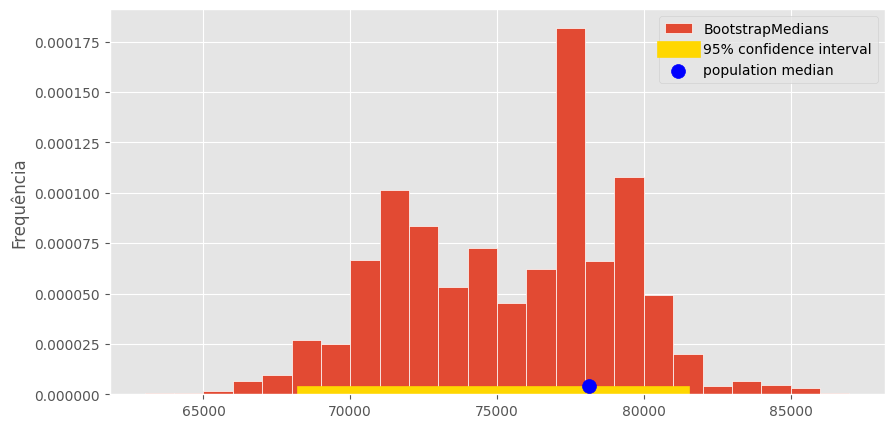

In [27]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5), zorder=1)
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval', zorder=2);
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median', zorder=3)
plt.legend()
plt.ylabel("Frequência");

- Nesse exemplo, note que nosso IC95% (representado pela <span style="color:gold"><b>linha dourada</b></span>) contém o verdadeiro valor do parâmetro, isto é, a mediana populacional (representada pelo <span style="color:blue"><b>ponto azul</b></span>).
    - Note que _isso nem sempre acontece_, pois a amostra original pode não ser tão boa!
    - Na prática, além de não saber o quão próxima a mediana amostral está da mediana populacional, em geral também não saberemos o quão boa a nossa amostra original realmente é.
    - Discutiremos na próxima aula algumas maneiras de contornar esse problema.

- Finalmente, note pelo histograma acima que nesse exemplo a distribuição bootstrap não está centrada na _mediana populacional_ (de \\$78,136), mas sim na _mediana amostral_ (\\$76,237).

### Teste Rápido ✅

Suponha que tenhamos calculado o seguinte IC95%:

In [28]:
print('Interval:', [left, right])
print('Width:', right - left)

Interval: [68469.0, 81253.5]
Width: 12784.5


onde `Width` acima representa a **largura** do IC, i.e. se $IC95\% = [y, x]$, sua largura é igual a $y - x$. 

Agora, se ao invés de 95\% de confiança tivéssemos calculado um intervalo de 80% de confiança, isto é, um IC80\%, você acha que esse intervalo seria _mais largo_ ou _mais estreito_ do que o IC95%?

- A.  Mais largo
- B.  Mais estreito
- C.  É impossível dizer

### Para refletir

Na aula anterior, aprendemos a fazer afirmativas do tipo

> Acreditamos que a mediana populacional está "próxima" da nossa mediana amostral, \\$76,237.

Nessa aula, aprendemos a fazer afirmativas do tipo

> Podemos dizer, com "95% de confiança", que a mediana populacional está entre \\$68,469 e \\$81,253.50.

Restam ainda, porém, algumas dúvidas fundamentais:

- O que "95% de confiança" significa?
- Sobre o que exatamente estamos confiantes?
- Esse tipo de técnica é sempre aplicável?

## Resumo e próxima aula

### Resumo

- Com base em uma amostra, queremos inferir sobre um parâmetro populacional. Porém, como podemos calcular apenas uma estimativa com essa amostra, em geral não sabemos o quão _precisa_ é essa estimativa.
    - Para termos uma ideia do quão variável é nossa estimativa, idealmente coletaríamos mais amostras e calcularíamos nossa estatística em cada uma dessas amostras. Porém, na prática, amostrar em geral é caro, e logo usualmente temos disponível **apenas uma amostra**.
- **Ideia principal**: Sob certas condições, a amostra é distribuída de maneira bem similar à população da qual a amostra foi coletada. Dessa forma, podemos tratar a distribuição empírica da amostra como se fosse a distribuição populacional e produzir novas amostras **reamostrando** da amostra original.
    - Cada nova amostra produzida dessa forma gera nos permite calcular uma nova estimativa. Com base em um conjunto dessas estimativas, podemos então ter uma noção da precisão/variabilidade da nossa estimativa original.
- O **Bootstrap** nos fornece uma maneira de gerarmos uma distribuição empírica de uma estatística, utilizando apenas uma única amostra original. Com base nessa **distribuição bootstrap**, podemos criar intervalos de $c$% confiança identificando os valores cujo intervalo contenha $c$% da distribuição entre si.
    - Podemos assim **quantificar a incerteza** sobre nossas estimativas, e fazer afirmações do tipo "a média populacional está entre \\$68,469 to \\$81,253.50" ao invés de afirmar apenas que "a média populacional é aproximadamente \\$76,237".

### Próxima aula

- Vamos definir e explicar melhor o nível de confiança, e aprender a interpretar de maneira mais precisa os intervalos de confiança.
- Vamos aprender a identificar estatísticas para as quais o bootstrap não funciona tão bem.
- Vamos aprender a quantificar a variabilidade em uma distribuição.